
x, y area given as 1D ‘nominal’ longitudes and latitudes. This means the x is the zonal average latitude (can become difficult near the Arctic, but is otherwise very useful) and y is the longitude at the equator.

lon and lat are 2-dimensional coordinate arrays with the ‘true’ position of grid cells (if the values were initially given as 1d arrays, they are broadcasted appropriately)

Dimensions are the names assigned to each array axis. 
Coordinates define labels along the axis.

https://cmip6-preprocessing.readthedocs.io/en/latest/postprocessing.html
https://cmip6-preprocessing.readthedocs.io/en/latest/tutorial.html




In [2]:
import xarray 
import os 
import xmip
import numpy as np
#Lmon =  xarray.open_mfdataset(f'data/Lmon/*.nc',compat='minimal')
Amon =  xarray.open_mfdataset(f'data/Amon/*.nc',compat='minimal')
Omon =  xarray.open_mfdataset(f'data/Omon/*.nc',compat='minimal')
#Lmon = Lmon.drop_vars(['time_bounds'])
Amon = Amon.drop_vars(['time_bounds'])
Omon = Omon.drop_dims(['nvertex'])
Omon = Omon.drop_vars(['area','time_bounds'])
#Omon = Omon.drop_vars(['nav_lat','nav_lon'])
# Omon = Omon.assign_coords({'nav_lon':Omon.nav_lon-10})
from xmip.preprocessing import promote_empty_dims, broadcast_lonlat, replace_x_y_nominal_lat_lon
from xmip.preprocessing import rename_cmip6
from xmip.preprocessing import correct_units,correct_lon
from xmip.preprocessing import correct_coordinates,parse_lon_lat_bounds, maybe_convert_bounds_to_vertex, maybe_convert_vertex_to_bounds

def _interp_nominal_lon_new(lon_1d):
    print('Using altered version')
    x = np.arange(len(lon_1d))
    print(x)
    idx = np.isnan(lon_1d)
    # TODO assume that longitudes are cyclic (i.e., don't)
    ret = np.interp(x, x[~idx], lon_1d[~idx], period=len(lon_1d))
    return ret

xmip.preprocessing._interp_nominal_lon = _interp_nominal_lon_new

ds = Omon.copy()
ds = rename_cmip6(ds)
ds = promote_empty_dims(ds)
ds = broadcast_lonlat(ds)


OSError: no files to open

In [1]:
from xmip.postprocessing import (
    interpolate_grid_label
)

In [4]:
import xesmf as xe
regridder = xe.Regridder(ds, ds_out, "conservative")
regridder  # print basic regridder information.

ModuleNotFoundError: No module named 'ESMF'

In [2]:
ddict
interpolate_grid_label()

ValueError: This function needs the optional package xesmf. Please install with `conda install -c conda-forge xesmf`.

In [2]:

def replace_x_y_nominal_lat_lon(ds):
    """Approximate the dimensional values of x and y with mean lat and lon at the equator"""
    ds = ds.copy()

    def maybe_fix_non_unique(data, pad=False):
        """remove duplicate values by linear interpolation
        if values are non-unique. `pad` if the last two points are the same
        pad with -90 or 90. This is only applicable to lat values"""
        if len(data) == len(np.unique(data)):
            print('no pad')
            return data
        else:
            # pad each end with the other end.
            if pad:
                if len(np.unique([data[0:2]])) < 2:
                    data[0] = -90
                if len(np.unique([data[-2:]])) < 2:
                    data[-1] = 90

            ii_range = np.arange(len(data))
            _, indicies = np.unique(data, return_index=True)
            double_idx = np.array([ii not in indicies for ii in ii_range])
            # print(f"non-unique values found at:{ii_range[double_idx]})")
            data[double_idx] = np.interp(
                ii_range[double_idx], ii_range[~double_idx], data[~double_idx]
            )
            
            return data

    if "x" in ds.dims and "y" in ds.dims:
        # define 'nominal' longitude/latitude values
        # latitude is defined as the max value of `lat` in the zonal direction
        # longitude is taken from the `middle` of the meridonal direction, to
        # get values close to the equator

        # pick the nominal lon/lat values from the eastern
        # and southern edge, and
        eq_idx = len(ds.y) // 2

        nominal_x = ds.isel(y=eq_idx).lon.load()
        nominal_y = ds.lat.max("x").load()
        print(nominal_x.data)
        # interpolate nans
        # Special treatment for gaps in longitude
        # nominal_x = _interp_nominal_lon_new(nominal_x.data)
        nominal_x = nominal_x.interpolate_na("x").data
        nominal_y = nominal_y.interpolate_na("y").data
        # nominal_x = nominal_x - 0.5
        # print(nominal_x)
        # eliminate non unique values
        # these occour e.g. in "MPI-ESM1-2-HR"
        # nominal_y = maybe_fix_non_unique(nominal_y)
        # nominal_x = maybe_fix_non_unique(nominal_x)
        # ds['tos'].isel(time=0).plot()
        # print(ds.x)
        # print(len(ds.x))
        # print(len(nominal_x))
        ds = ds.assign_coords(x=nominal_x, y=nominal_y)
        ds = ds.sortby("x")
        ds = ds.sortby("y")
        # ds['tos'].isel(time=0).plot()

        # do one more interpolation for the x values, in case the boundary values were
        # affected
        print(ds.x.load().data)
        ds = ds.assign_coords(
            x=maybe_fix_non_unique(ds.x.load().data,pad=False),
            y=maybe_fix_non_unique(ds.y.load().data, pad=True),
        )
        print(ds.x)
    else:
        warnings.warn(
            "No x and y found in dimensions for source_id:%s. This likely means that you forgot to rename the dataset or this is the German unstructured model"
            % ds.attrs["source_id"]
        )
    return ds

In [3]:
ds = replace_x_y_nominal_lat_lon(ds)


[  72.5   73.5   74.5   75.5   76.5   77.5   78.5   79.5   80.5   81.5
   82.5   83.5   84.5   85.5   86.5   87.5   88.5   89.5   90.5   91.5
   92.5   93.5   94.5   95.5   96.5   97.5   98.5   99.5  100.5  101.5
  102.5  103.5  104.5  105.5  106.5  107.5  108.5  109.5  110.5  111.5
  112.5  113.5  114.5  115.5  116.5  117.5  118.5  119.5  120.5  121.5
  122.5  123.5  124.5  125.5  126.5  127.5  128.5  129.5  130.5  131.5
  132.5  133.5  134.5  135.5  136.5  137.5  138.5  139.5  140.5  141.5
  142.5  143.5  144.5  145.5  146.5  147.5  148.5  149.5  150.5  151.5
  152.5  153.5  154.5  155.5  156.5  157.5  158.5  159.5  160.5  161.5
  162.5  163.5  164.5  165.5  166.5  167.5  168.5  169.5  170.5  171.5
  172.5  173.5  174.5  175.5  176.5  177.5  178.5  179.5 -179.5 -178.5
 -177.5 -176.5 -175.5 -174.5 -173.5 -172.5 -171.5 -170.5 -169.5 -168.5
 -167.5 -166.5 -165.5 -164.5 -163.5 -162.5 -161.5 -160.5 -159.5 -158.5
 -157.5 -156.5 -155.5 -154.5 -153.5 -152.5 -151.5 -150.5 -149.5 -148.5
 -147.

In [4]:
# ds = replace_x_y_nominal_lat_lon(ds)
ds = correct_lon(ds)
ds = correct_coordinates(ds)
ds = parse_lon_lat_bounds(ds)
ds = maybe_convert_bounds_to_vertex(ds)
ds = maybe_convert_vertex_to_bounds(ds)
ds = ds.assign_coords({'x':ds.x-0.5})

In [5]:
ds.rio.set_spatial_dims('x', 'y', inplace=True)
ds.rio.write_crs("epsg:4326",inplace=True)
# Omon.rio.write_crs(4326,inplace=True)
Amon.rio.write_crs(4326,inplace=True)
ds.rio.set_spatial_dims('x', 'y', inplace=True)
ds = ds.drop_vars(['lat','lon'])
Omon_reproj = ds.rio.reproject_match(Amon)

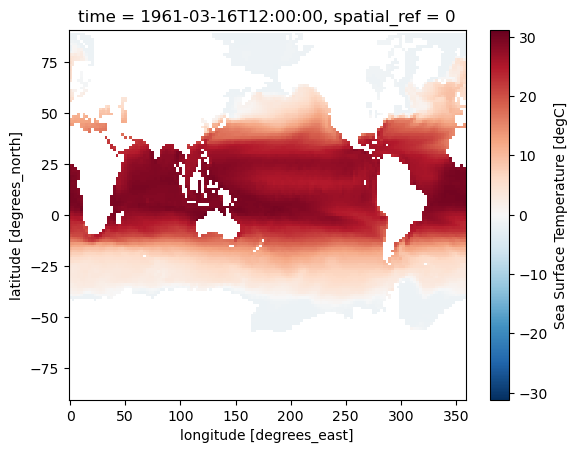

In [8]:
Omon_reproj.isel(time=2)['tos'].plot()